In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import pandas as pd
from datetime import timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', 50) 

import os

def get_year_month(df):  
    df['year_month'] = df['DATE'].map(lambda x: datetime(x.year, x.month, 1).date())
    return df

def filter_date(df,start_date, end_date, date_col='year_month'):
    return df.query('{dtcol} >= "{}" and {dtcol} <= "{}"'.format(start_date, end_date, dtcol=date_col))

def read_csv(file):
    '''
    with parse_date
    '''
    return pd.read_csv(file, parse_dates=['DATE'])

os.listdir('data/Loans Stats/')


['archive_2021_06',
 'archive_2021_12',
 'archive_2022_03',
 'Banking Stats.XLS',
 'Banking stats_2.XLS']

### Parameters

In [7]:
image_folder = 'output'

file_1 = 'data/Loans Stats/Banking Stats.XLS'
file_2 = 'data/Loans Stats/Banking stats_2.XLS'

start_date = "2010-01-01"

opr_df         = read_csv('data/opr/opr_rate.csv')
end_date = opr_df["DATE"].max() - pd.offsets.BMonthEnd(1)
# end_date = "2022-02-28"  # to update
print("End Date:", end_date)

End Date: 2022-03-31 00:00:00


### Read Data

In [8]:
loan_3_df        = pd.read_excel(file_1, sheet_name='Loan_3')
int_df           = pd.read_excel(file_1, sheet_name='Int')
npl_df           = pd.read_excel(file_1, sheet_name='NPL')[['Unnamed: 0','Unnamed: 17']]
application_df = pd.read_excel(file_2, sheet_name='Applications by purpose', header=None)
approval_df    = pd.read_excel(file_2, sheet_name='Approvals by purpose', header=None)


opr_df         = read_csv('data/opr/opr_rate.csv').pipe(get_year_month).pipe(filter_date, start_date, end_date, "DATE")
m3_price       = read_csv('data/opr/m3_rate.csv').pipe(get_year_month).pipe(filter_date, start_date, end_date, "DATE") 
srr            = read_csv('data/opr/srr_rate.csv').pipe(get_year_month).pipe(filter_date, start_date, end_date, "DATE")
bond_yields    = read_csv('data/opr/magy10yr.csv').pipe(filter_date, start_date, end_date, "DATE")

### Data Processing

In [9]:
def trim_df(df):
    dff = df[list(range(15))].copy()
    dff.columns  = dff.iloc[3][:2].append(dff.iloc[2][2:]).tolist()
    dff = dff.iloc[4:].copy().dropna(subset=['Month'])
    dff['Year'] = dff['Year'].ffill()
    dff['year_month'] = dff.apply(lambda x: '{}-{}-01'.format(x['Year'], str(x['Month']).zfill(2)),1)
    return dff

def process_npl(npl):
    npl.columns= ['Date', 'Gross NPL']
    npl = npl.iloc[npl[npl['Date']=='Monthly'].index[0]+1:].dropna().copy()
    npl['Date'] = pd.to_datetime(npl['Date'])
    return npl

def process_opr(opr_df):
    def label(x):
        if x > 0:
            return 'hike'
        elif x< 0 :
            return 'cut'
        else:
            return 'stay'
    
    opr_df['label'] = opr_df['px_last'].diff().map(label) 
    opr_month = pd.pivot_table(opr_df, index='year_month', columns='label', values='px_last').fillna(0)\
                  .applymap(lambda x: 1 if x!= 0 else 0).reset_index()
    opr_month['label'] = opr_month.apply(lambda x: 'cut' if x['cut']==1 else ('hike' if x['hike'] == 1 else 'stay'), 1)
    return opr_df, opr_month

application_df_1 = trim_df(application_df).pipe(filter_date, start_date, end_date)
approval_df_1 = trim_df(approval_df).pipe(filter_date, start_date, end_date).\
                                    rename(columns={'Residential':'Residential mortgages',
                                                    'Non-residential':'Non-residential mortgages',
                                                     'Consumer goods':'Consumer durable goods', 
                                                    'Other ':'Other purpose'})
npl = process_npl(npl_df).pipe(filter_date, start_date, end_date, "Date")
opr_df, opr_month = process_opr(opr_df)

### Visualization

In [10]:
def add_title(fig, title, ylabel="Amount (billion) [MYR]"):
    fig.update_layout(template='ygridoff',
                      title=title,
                    yaxis=dict(
                    title=ylabel,
                ),
                )
    return fig


def plot_multi_lines(df, x_axis, y_axes):
    fig = go.Figure()
    for col in y_axes:
        fig.add_trace(go.Scatter(x=df[x_axis], y=df[col]/1000, name=col))
    fig.update_xaxes(dtick='M12')
    return fig


### Overview of Bank Loan Stats

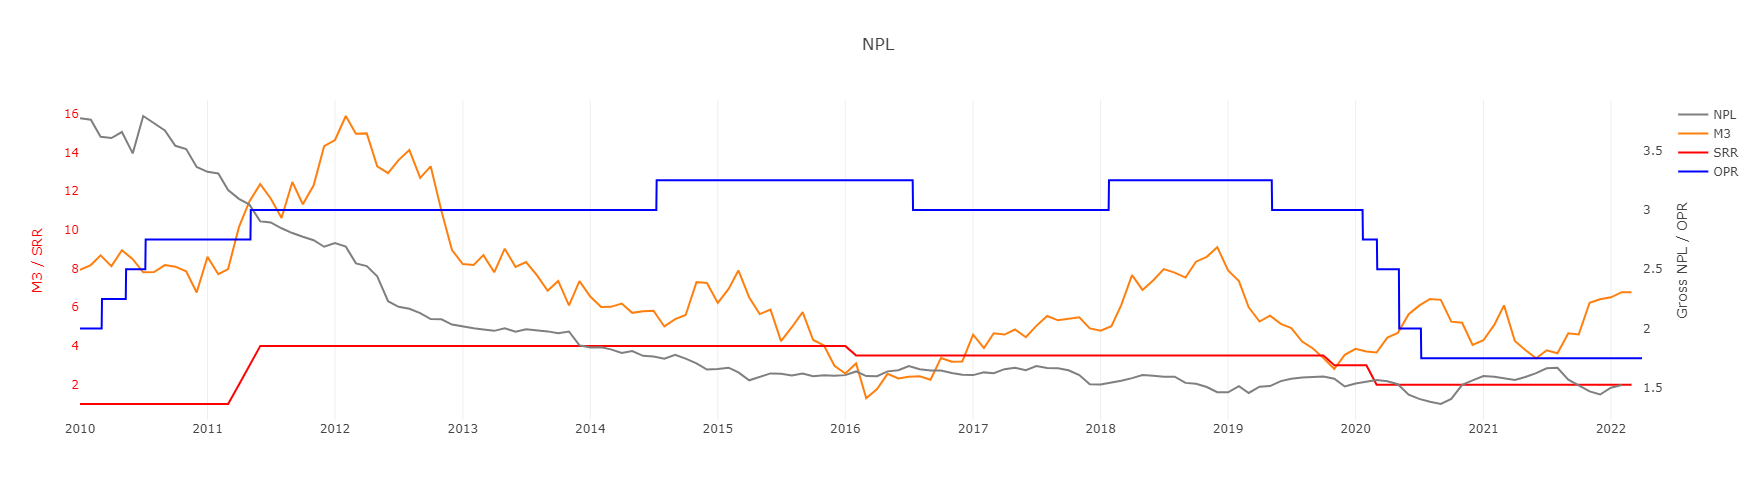

In [39]:
m3_price_m = m3_price.groupby(['ID','year_month'])['px_last'].last().reset_index()
srr_m = srr.groupby(['ID','year_month'])['px_last'].last().reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(x = npl['Date'],
                         y = npl['Gross NPL'],
                         marker_color='#7f7f7f',
                         name = 'NPL',
                        yaxis="y2"))

fig.add_trace(go.Scatter(x = m3_price_m['year_month'],
                         y = m3_price_m['px_last'],
                         marker_color='#ff7f0e',
                         name = 'M3'),
             )

fig.add_trace(go.Scatter(x = srr_m['year_month'],
                         y = srr_m['px_last'],
                         marker_color='red',
                         name = 'SRR'),
             )


fig.add_trace(go.Scatter(x = opr_df['DATE'],
                         y = opr_df['px_last'],
                         marker_color='blue',
                         mode='lines',
                         name = 'OPR',
                         yaxis="y2"),
             )

fig.update_layout(
    title='NPL',
    yaxis=dict(
        title="M3 / SRR",
        titlefont=dict(
            color="red"
        ),
        tickfont=dict(
            color="red"
        )
    ),
    yaxis2=dict(
        title="Gross NPL / OPR",
        anchor="x",
        overlaying="y",
        side="right",
        position=0.85
    )
)

fig.update_layout(
    template='ygridoff',
    xaxis = dict(
        dtick = "M12"
    )
)
fig.update_layout(
    autosize=False,
    width=1100,
    height=500,)


In [62]:
# display(m3_price_m.tail(13))
# display(npl.tail(13))

x1 = m3_price_m.tail(13)
d1, d2 = x1.year_month.values[0], x1.year_month.values[-1]
t1, t2 = x1.loc[:, "px_last"].values[0], x1.loc[:, "px_last"].values[-1]
print(d1, t1, d2, t2)

x1 = npl.tail(13)
d1, d2 = x1.Date.values[0], x1.Date.values[-1]
t1, t2 = x1.loc[:, "Gross NPL"].values[0], x1.loc[:, "Gross NPL"].values[-1]
print(d1, t1, d2, t2)



2021-03-01 6.09775 2022-03-01 6.77914
2021-02-01T00:00:00.000000000 1.5949061285705237 2022-02-01T00:00:00.000000000 1.5252161673969946


### Total Bank Loan Application and Approval

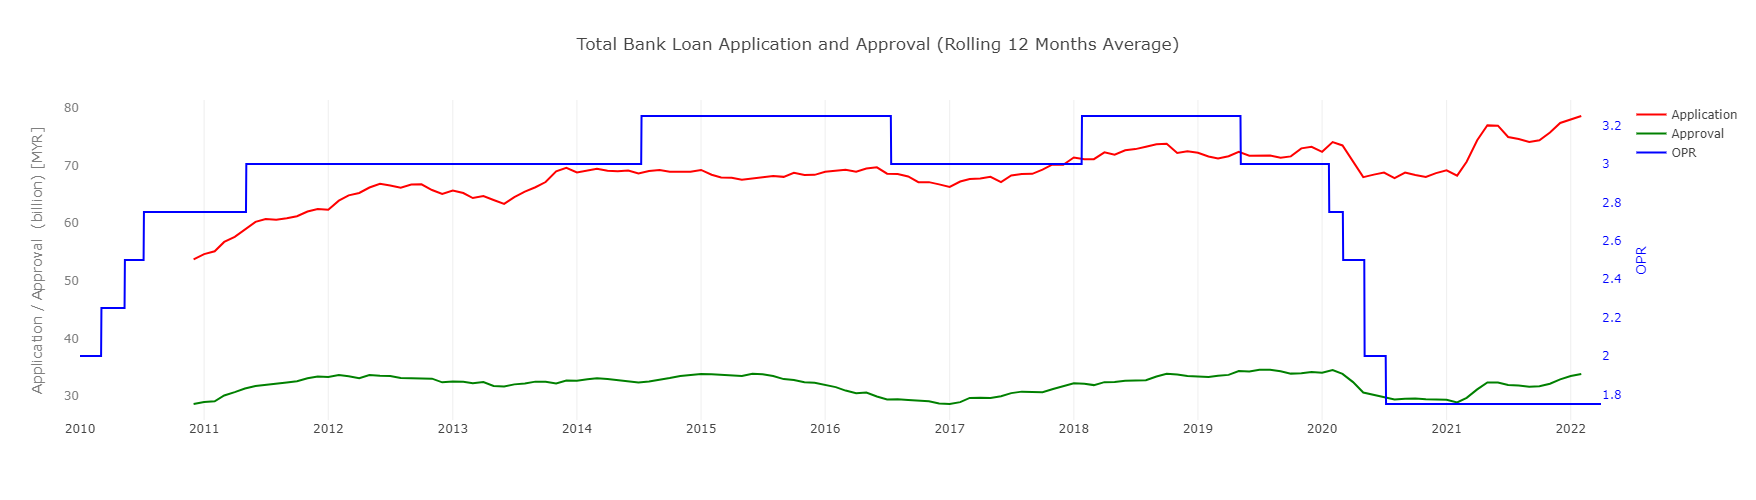

In [90]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = application_df_1.dropna()['year_month'],
                         y = application_df_1.dropna()['TOTAL'].rolling(12).mean()/1000,
                         marker_color='red',
                         name = 'Application'))

fig2.add_trace(go.Scatter(x = approval_df_1.dropna()['year_month'],
                         y = approval_df_1.dropna()['TOTAL'].rolling(12).mean()/1000,
                         marker_color='green',
                        name = 'Approval'),
             )

fig2.add_trace(go.Scatter(x = opr_df.query('DATE >= "2006-01-01"')['DATE'],
                         y = opr_df.query('DATE >= "2006-01-01"')['px_last'],
                         marker_color='blue',
                         mode='lines',
                         name = 'OPR',
                        yaxis="y2"),
             )

fig2.update_layout(
    title='Total Bank Loan Application and Approval (Rolling 12 Months Average)',
    yaxis=dict(
        title="Application / Approval  (billion) [MYR]",
        titlefont=dict(
            color="#7f7f7f"
        ),
        tickfont=dict(
            color="#7f7f7f"
        )
    ),
    yaxis2=dict(
        title="OPR",
        titlefont=dict(
            color="blue"
        ),
        tickfont=dict(
            color="blue"
        ),
        anchor="x",
        overlaying="y",
        side="right",
        position=0.85
    )
)

fig2.update_layout(
    template='ygridoff',
    xaxis = dict(
        dtick = "M12"
    )
)
fig2.update_layout(
    autosize=False,
    width=1100,
    height=500,)


In [55]:
x1 = application_df_1.tail(13)
d1, d2 = x1.Date.values[0], x1.Date.values[-1]
t1, t2 = x1.loc[:, "TOTAL"].values[0], x1.loc[:, "TOTAL"].values[-1]
print(d1, t1, d2, t2)

x1 = approval_df_1.tail(13)
d1, d2 = x1.Date.values[0], x1.Date.values[-1]
t1, t2 = x1.loc[:, "TOTAL"].values[0], x1.loc[:, "TOTAL"].values[-1]
print(d1, t1, d2, t2)


2021-02-01T00:00:00.000000000 59007.185000000005 2022-02-01T00:00:00.000000000 66699.19809
2021-02-01T00:00:00.000000000 24526.629999999997 2022-02-01T00:00:00.000000000 28929.189290000002


In [13]:

application_df_1["Date"] = pd.to_datetime(application_df_1["year_month"])
purposes = [i for i in application_df_1 if i not in ['Date', 'Year','Month','TOTAL','year_month','Auto','Consumer durable goods']]
purposes
application_df_1a = application_df_1.set_index("Date")[purposes]
application_df_2 = application_df_1a.rolling(12).mean()
approval_df_1["Date"] = pd.to_datetime(approval_df_1["year_month"])
approval_df_1a = approval_df_1.set_index("Date")[purposes]
approval_df_2 = approval_df_1a.rolling(12).mean()


### Loan App & Approval

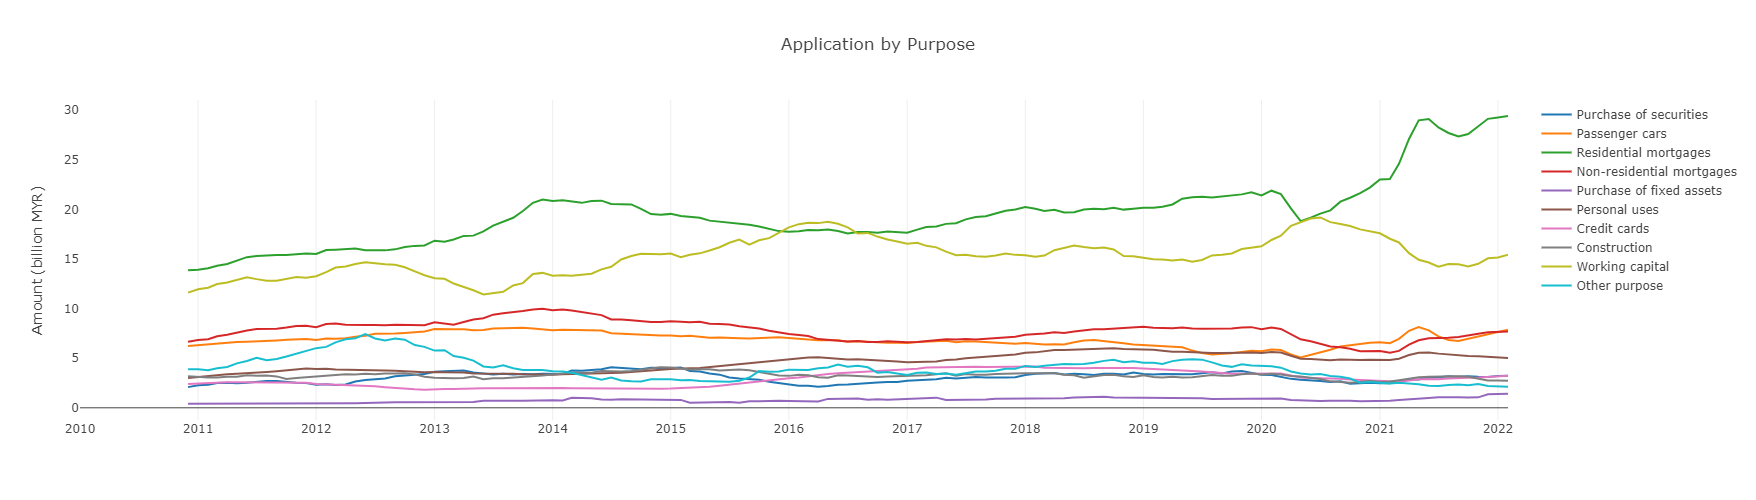

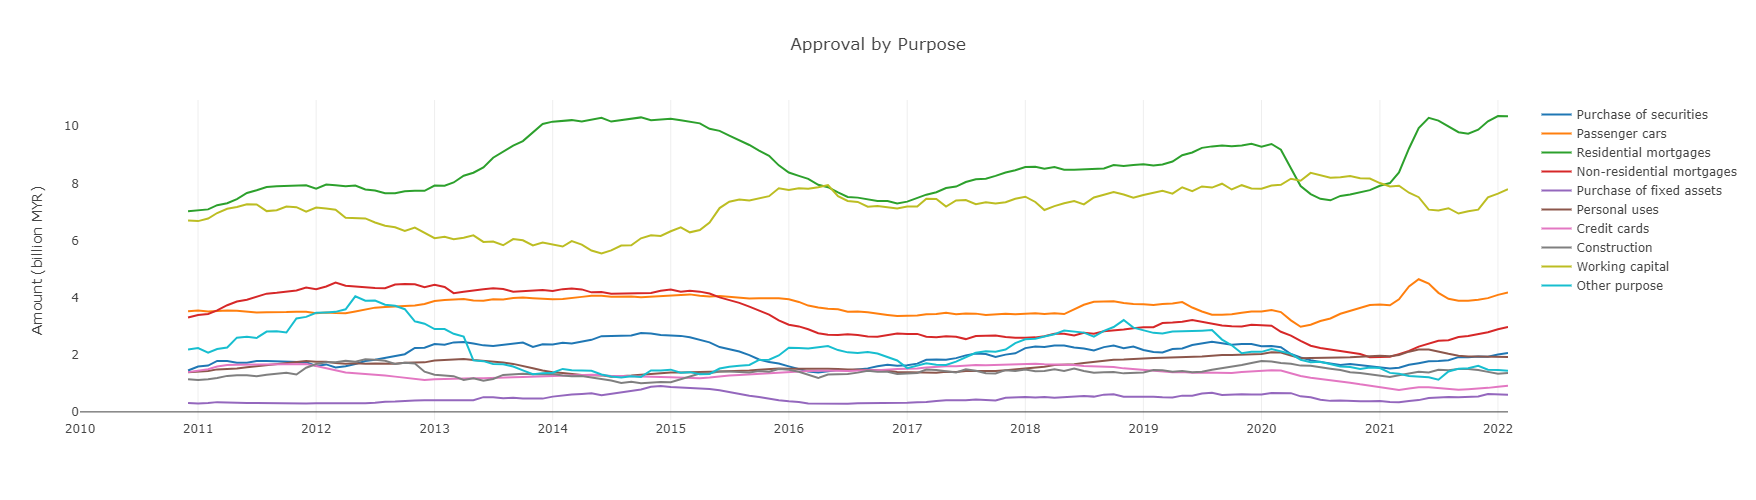

In [64]:
fig_application = plot_multi_lines(application_df_2.reset_index(), 'Date', purposes)
fig_application = add_title(fig_application, 'Application by Purpose', ylabel = "Amount (billion MYR)")
fig_application.update_layout(
    autosize=False,
    width=1100,
    height=500,).show()

fig_approval = plot_multi_lines(approval_df_2.reset_index(), 'Date', purposes)
fig_approval = add_title(fig_approval, 'Approval by Purpose', ylabel = "Amount (billion MYR)")
fig_approval.update_layout(
    autosize=False,
    width=1100,
    height=500,).show()



In [88]:
a1 = approval_df_2.loc["2014", ["Residential mortgages"]]
a2 = approval_df_2.loc["2022", ["Residential mortgages"]]
pd.concat([a1, a2])

,Residential mortgages
Date,
2014-01-01,10159.187667
2014-02-01,10197.242000
2014-03-01,10211.688667
2014-04-01,10165.531167
2014-05-01,10228.915417
2014-06-01,10293.913917
2014-07-01,10160.633417
2014-08-01,10206.128667
2014-09-01,10259.482000


In [77]:
# application_df_1["Date"] = pd.to_datetime(application_df_1["year_month"])
# application_df_1a = application_df_1[purposes].set_index("Date")
# application_df_1a

In [16]:
def preproc_app_df(df):
    app_df_1 = df.pct_change(12).loc[df.index[-4]:]
    col_1 = app_df_1.T.columns[-1]
    new_col = [j.strftime("%b%y-YoY") for j in app_df_1.T.columns]
    table_application_1 = (  app_df_1.T.sort_values(col_1, ascending=False)*100).round(2)
    table_application_1.columns = new_col
    return table_application_1

preproc_app_df(application_df_1a)

,Nov21-YoY,Dec21-YoY,Jan22-YoY,Feb22-YoY
Passenger cars,32.77,32.90,47.56,45.13
Credit cards,8.60,17.46,29.70,38.93
Working capital,22.35,56.74,8.08,29.35
Purchase of securities,-18.10,-6.46,36.87,17.63
Non-residential mortgages,33.56,29.82,1.30,11.18
Residential mortgages,36.09,33.79,6.45,8.54
Personal uses,-6.31,-9.64,-13.17,-15.25
Purchase of fixed assets,16.81,577.04,66.79,-16.07
Other purpose,104.54,-73.70,-37.41,-16.39
Construction,-50.83,-47.45,2.77,-18.17


In [17]:
preproc_app_df(approval_df_1a)

,Nov21-YoY,Dec21-YoY,Jan22-YoY,Feb22-YoY
Credit cards,23.66,36.57,63.53,62.93
Non-residential mortgages,39.05,31.62,51.69,49.34
Purchase of securities,16.91,-8.67,72.28,47.07
Construction,-21.25,-48.35,-38.93,43.33
Working capital,8.25,66.41,30.49,36.11
Passenger cars,7.53,14.59,33.94,31.21
Residential mortgages,16.66,37.85,25.27,-1.82
Personal uses,1.10,-0.43,3.13,-11.23
Purchase of fixed assets,87.79,250.57,-38.01,-18.39
Other purpose,74.05,-61.70,-7.24,-60.24


In [26]:
approval_df_1a.tail(15)

,Purchase of securities,Passenger cars,Residential mortgages,Non-residential mortgages,Purchase of fixed assets,Personal uses,Credit cards,Construction,Working capital,Other purpose
Date,,,,,,,,,,
2020-12-01,1497.811,4617.374,9270.008,2343.882,406.036,2300.004,972.44301,1644.443,7784.901,2643.754
2021-01-01,1324.872,4025.135,8884.867,2395.118,476.271,2033.486,771.796,1961.879,5159.191,1235.869
2021-02-01,1291.962,3274.614,8355.694,2075.231,407.281,2007.341,591.321,727.12,5085.879,514.125
2021-03-01,2458.59,5427.295,10871.845,3032.241,299.207,2414.584,882.966,1761.977,7936.841,1511.296
2021-04-01,1900.868,5578.426,12573.414,3119.423,690.861,2078.569,919.759,1264.912,6452.285,867.746
2021-05-01,1386.866,4381.52,12019.231,2654.035,563.465,1743.839,730.765,1549.315,7047.921,431.591
2021-06-01,2657.572,1985.748,10544.962,2510.447,1132.25,1766.38,675.415,972.396,6449.539,1235.898
2021-07-01,1601.348,1398.63,7940.089,2887.681,703.398,1403.16,631.154,2184.84,6524.812,1384.682
2021-08-01,2023.641,2072.041,7261.126,2319.043,397.137,1389.752,612.192,1030.324,7873.5105,4200.413


---
### Top 3 sectors

In [18]:
lowest = application_df_1.query('Year == 2020').query('Month == 4').index[0]
latest = application_df_1.index[-1]
window = int(latest-lowest)
print(window, type(window))

top_3_recoveries = application_df_1[purposes].diff(window).iloc[-1].sort_values(ascending=False)[:3].index
top_3_recoveries

22 <class 'int'>


Index(['Residential mortgages', 'Passenger cars', 'Non-residential mortgages'], dtype='object')

In [19]:

def appl_vs_approv(col, smooth=True):
    p_df = application_df_1[['year_month',col]].rename(columns={col:'Application'})\
                        .merge(approval_df_1[['year_month',col]].rename(columns={col:'Approval'})).copy()
    if smooth:
        p_df['Application'] = p_df['Application'].rolling(12).mean()
        p_df['Approval'] = p_df['Approval'].rolling(12).mean()
    fig = plot_multi_lines(p_df, 'year_month', ['Application','Approval'])
    fig = add_title(fig, col)
    return fig


In [24]:
application_df_1.tail(12)["Date"]

,Year,Month,Purchase of securities,Auto,Passenger cars,Residential mortgages,Non-residential mortgages,Purchase of fixed assets,Personal uses,Credit cards,Consumer durable goods,Construction,Working capital,Other purpose,TOTAL,year_month,Date
186,2021,3,4035.132,10772.47,10304.096,36142.102,8707.618,1623.959,6371.239,2996.954,45.039,3970.243,16745.036,2827.631,94237.423,2021-03-01,2021-03-01
187,2021,4,3004.441,10905.079,10461.235,36740.881,9430.79,1416.722,6017.375,2934.494,0.028,4237.64,16701.969,2218.936,93608.355,2021-04-01,2021-04-01
188,2021,5,2653.941,7592.894,7138.037,33010.433,7941.362,1297.48,4871.416,2618.381,0,3578.152,14175.752,1885.973,79625.784,2021-05-01,2021-05-01
189,2021,6,4585.227,3890.262,3578.428,27101.597,7244.168,1315.59,4859.217,2618.695,0.011,2274.179,14940.596,1122.225,69951.767,2021-06-01,2021-06-01
190,2021,7,2956.253,2691.535,2474.258,19663.107,6064.528,1621.35,4030.438,2980.163,0.004,2557.728,12924.979,3776.751,59266.836,2021-07-01,2021-07-01
191,2021,8,3684.78,4116.272,3733.787,20768.728,6056.089,1151.386,4073.52,3879.268,0.027,2249.111,17399.2185,3273.98,66652.3795,2021-08-01,2021-08-01
192,2021,9,2603.489,7809.52,7356.839,26808.917,7347.678,424.176,4777.067,4248.359,0.006,2499.5,15247.502,2877.521,74643.735,2021-09-01,2021-09-01
193,2021,10,3579.19,10288.904,9875.406,31892.199,8405.187,614.327,5553.258,2967.25699,0.043,2365.935,13378.779,824.011,79869.08999,2021-10-01,2021-10-01
194,2021,11,3091.958,11430.11,10943.15,35857.95,8889.459,1023.26,5374.782,3334.733,0.026,2366.446,17941.754,2819.615,92130.093,2021-11-01,2021-11-01
195,2021,12,1952.541,11554.289,10754.064,35172.06,8788.612,4337.442,5132.813,3668.71099,0.017,2082.95,18224.63,800.981,91715.04599,2021-12-01,2021-12-01


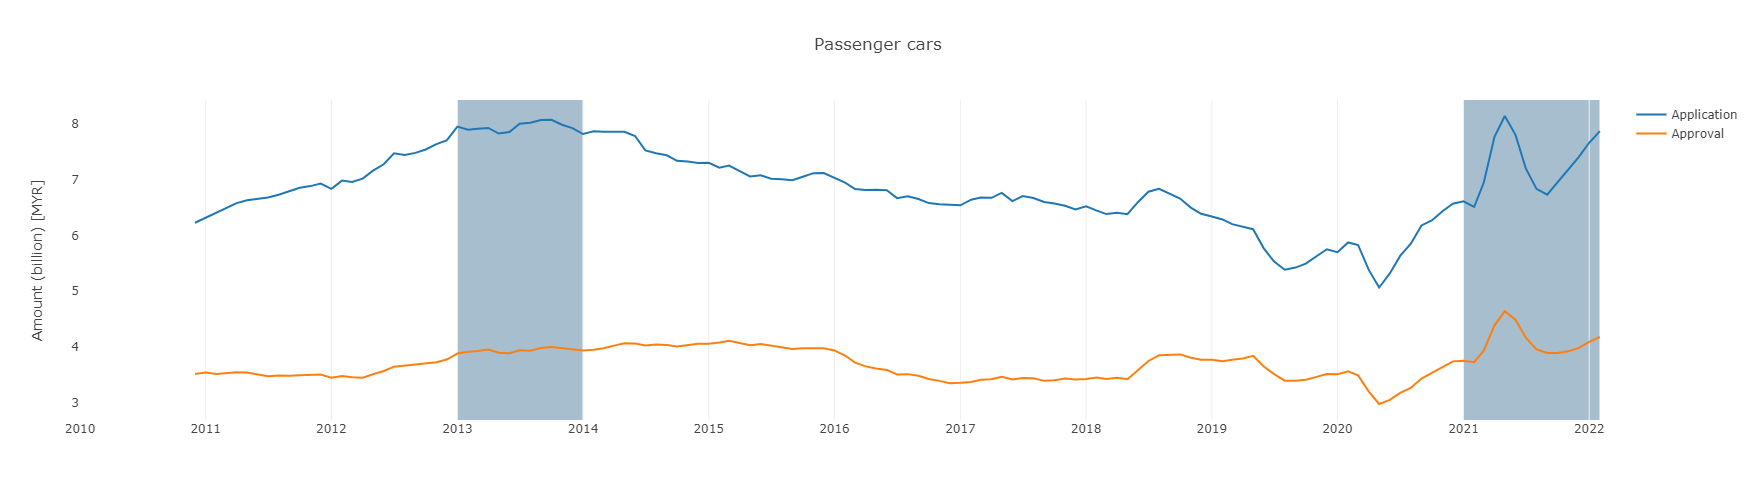

In [71]:
app_cols = ["Passenger cars", "Residential mortgages", "Credit cards"]
fig5 = appl_vs_approv(app_cols[0])
fig5a = fig5
fillcolor = "#a7becf"
layer = "below"
fig5a.add_shape(type="rect",
                        xref="x",
                        yref="paper",
                        x0="2013-01-01",
                        y0=0,
                        x1="2013-12-31",
                        y1=1,
                        line=dict(color="rgba(0,0,0,0)",width=3,),
                        fillcolor=fillcolor,
                        layer=layer) 
fig5a.add_shape(type="rect",
                        xref="x",
                        yref="paper",
                        x0="2021-01-01",
                        y0=0,
                        x1="2022-01-31",
                        y1=1,
                        line=dict(color="rgba(0,0,0,0)",width=3,),
                        fillcolor=fillcolor,
                        layer=layer) 

fig5a.update_layout(
    autosize=False,
    width=1100,
    height=500,).show()


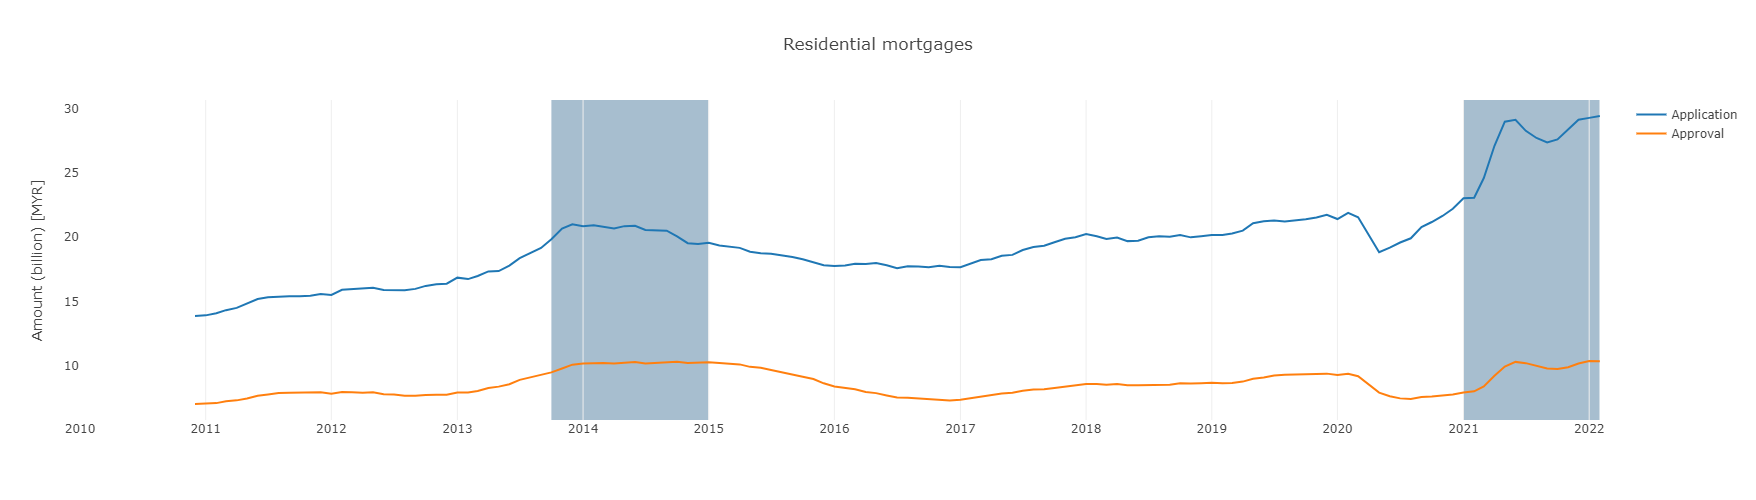

In [73]:
fig6 = appl_vs_approv(app_cols[1])
fig6a = fig6

fillcolor = "#a7becf"
layer = "below"
dt1, dt2 = "2013-10-01", "2014-12-31"
dt1b, dt2b = "2021-01-01", "2022-01-31"

fig6a.add_shape(type="rect",
                        xref="x",
                        yref="paper",
                        x0=dt1,
                        y0=0,
                        x1=dt2,
                        y1=1,
                        line=dict(color="rgba(0,0,0,0)",width=3,),
                        fillcolor=fillcolor,
                        layer=layer) 
fig6a.add_shape(type="rect",
                        xref="x",
                        yref="paper",
                        x0=dt1b,
                        y0=0,
                        x1=dt2b,
                        y1=1,
                        line=dict(color="rgba(0,0,0,0)",width=3,),
                        fillcolor=fillcolor,
                        layer=layer) 
fig6a.update_layout(
    autosize=False,
    width=1100,
    height=500,).show()


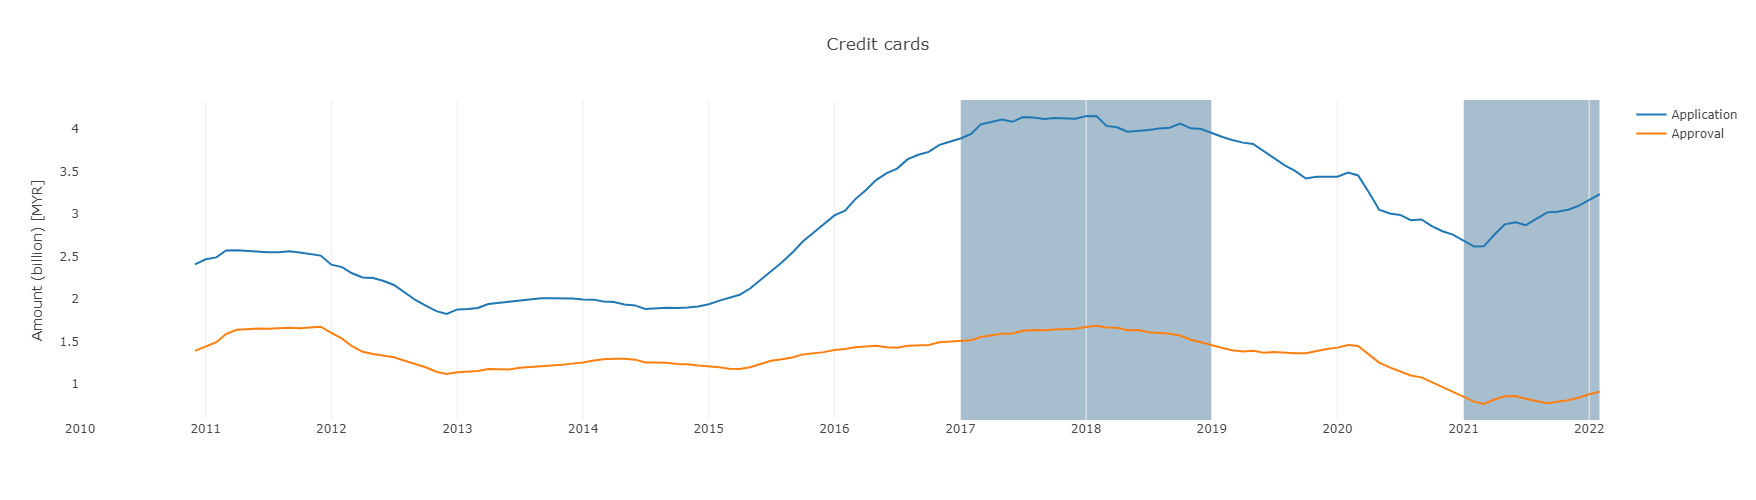

In [75]:
fig7 = appl_vs_approv(app_cols[2])
fig7a = fig7
fillcolor = "#a7becf"
layer = "below"
dt1, dt2 = "2017-01-01", "2018-12-31"
dt1b, dt2b = "2021-01-01", "2022-01-31"

fig7a.add_shape(type="rect",
                        xref="x",
                        yref="paper",
                        x0=dt1,
                        y0=0,
                        x1=dt2,
                        y1=1,
                        line=dict(color="rgba(0,0,0,0)",width=3,),
                        fillcolor=fillcolor,
                        layer=layer) 
fig7a.add_shape(type="rect",
                        xref="x",
                        yref="paper",
                        x0=dt1b,
                        y0=0,
                        x1=dt2b,
                        y1=1,
                        line=dict(color="rgba(0,0,0,0)",width=3,),
                        fillcolor=fillcolor,
                        layer=layer) 
fig7a.update_layout(
    autosize=False,
    width=1100,
    height=500,).show()